In [30]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [31]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, corr=0.5, multicol=0.0):
        self.size = size
        
        #create a baseline dataset with the correlations we want. This creates a series 
        #with mean zero and std=1 and the correlations specified by the covariance matrix (cov=)
        mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0], cov=[[1., corr, corr, corr], 
                                                                  [corr, 1., multicol, multicol],
                                                                  [corr, multicol, 1., multicol],
                                                                  [corr, multicol, multicol, 1.]])
        raw = mvnorm.rvs(self.size)
        #create the target variable with the specified targetskew
        targetMean = 6000
        targetStd = 2000
        
        if targetskew:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            sortedSkew = np.sort(stats.skewnorm.rvs(a=targetskew, loc=targetMean,scale=targetStd, size=self.size))
            self.hoursSpent = [sortedSkew[i-1] for i in intendedSortOrder]
            df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        else:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            self.hoursSpent = self.standardNormalTarget*targetStd + targetMean
            df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        
        
        #This adds a normally distributed feature with the correlations specified by the 2nd column of (cov=)
        #The std (3K) and mean (12K) are arbitrarily chosen to make the data intuitive (few/no negatives)
        df['screenActions'] = raw[:,1]*3000 + 12000
        df['screenActions'] = df['screenActions'].astype('int') 

        #This adds a uniformly distributed feature with the correlations specified by the 3rd column of (cov=)
        norm = stats.norm()
        uniformed = norm.cdf(raw[:,2])
        df['picsPerMonth'] = uniformed*500 + (np.max(uniformed) - np.min(uniformed))
        df['picsPerMonth'] = df['picsPerMonth'].astype('int') 

        #This adds a dual-peak gamma distribution for owner age
        
        gamma = stats.gamma(5)
        gam_uni = norm.cdf(raw[:,3])
        df['ownerAge'] = gamma.ppf(gam_uni)
        df['ownerAge'] = df['ownerAge']*4 + (np.max(df.ownerAge) - np.min(df.ownerAge))

        
        #This adds a poisson distribution that's typically around .17 correlation
        df['timesDropped'] = [np.random.poisson(lam=1.5) if x > targetMean else 
                              np.random.poisson(lam=1.0) for x in self.standardNormalTarget]


        #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
        df['rooted'] = [np.random.binomial(1, .05) if x > targetMean*1.5 else
                        np.random.binomial(1, .005) for x in self.standardNormalTarget]

        #This adds a categorical variable that slightly corresponds to the target
        def osChoice(self, p):
            return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
        df['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                               osChoice(self,[.335,.635,.03]) for x in self.standardNormalTarget]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [32]:
#this cell doesn't need to run; It checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)
#It's only useful when I update how a feature is calculated

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['hoursSpent','screenActions'])
    picscorrs.append(cor.loc['hoursSpent','picsPerMonth'])
    dropscorrs.append(cor.loc['hoursSpent','timesDropped'])
    agecorrs.append(cor.loc['hoursSpent','ownerAge'])
    rootcorrs.append(cor.loc['hoursSpent','rooted'])
print('Correlations: \n')
print('screenActions (Normal Variable)\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsPerMonth (Uniform Variable) \n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped (Poisson Variable) \n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge (Gamma Variable) \n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted (Bernoulli Variable)\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')
u.df.corr()

Correlations: 

screenActions (Normal Variable)
 0.5003429620188383 
 0.021969198975078045 

picsPerMonth (Uniform Variable) 
 0.48716919721475604 
 0.026062315802033074 

timesDropped (Poisson Variable) 
 0.00712034620605767 
 0.03379742739127004 

ownerAge (Gamma Variable) 
 0.4911691299130996 
 0.02319297034066261 

rooted (Bernoulli Variable)
 -0.006213494209150973 
 0.03391019340430756 

done in  3.932689905166626 seconds


,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted
hoursSpent,1.000000,0.546843,0.454506,0.478586,-0.006035,0.059451
screenActions,0.546843,1.000000,0.020530,0.000763,-0.039112,0.068678
picsPerMonth,0.454506,0.020530,1.000000,-0.038797,0.013334,0.010303
ownerAge,0.478586,0.000763,-0.038797,1.000000,-0.005046,0.016611
timesDropped,-0.006035,-0.039112,0.013334,-0.005046,1.000000,-0.016689
rooted,0.059451,0.068678,0.010303,0.016611,-0.016689,1.000000


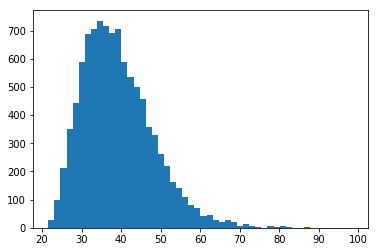

hoursSpent       -1272.1
screenActions      -1532
picsPerMonth           1
ownerAge         21.5863
timesDropped           0
rooted                 0
os               Android
dtype: object

hoursSpent       14141.8
screenActions      24806
picsPerMonth         500
ownerAge         98.5489
timesDropped           7
rooted                 1
os                 other
dtype: object

In [33]:
u = createSet(size=10000)
plt.hist(u.df.ownerAge, bins=50)
plt.show()
display(u.df.min())
display(u.df.max())

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [34]:
#Let's create one for vizualization

viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted,os
0,7077.054875,15103,478,28.125310,2,0,iOS
1,7042.582147,13478,281,37.741090,1,0,Android
2,4529.916822,9955,310,35.582661,1,0,iOS
3,7561.587886,16203,369,31.509446,4,0,Android
4,4771.990618,7664,358,31.076818,2,0,iOS


,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted
hoursSpent,1.000000,0.504599,0.481693,0.493986,-0.007733,0.009341
screenActions,0.504599,1.000000,-0.001456,0.003084,0.001324,-0.002008
picsPerMonth,0.481693,-0.001456,1.000000,-0.000204,-0.025049,0.001667
ownerAge,0.493986,0.003084,-0.000204,1.000000,-0.015246,0.008573
timesDropped,-0.007733,0.001324,-0.025049,-0.015246,1.000000,0.011132
rooted,0.009341,-0.002008,0.001667,0.008573,0.011132,1.000000


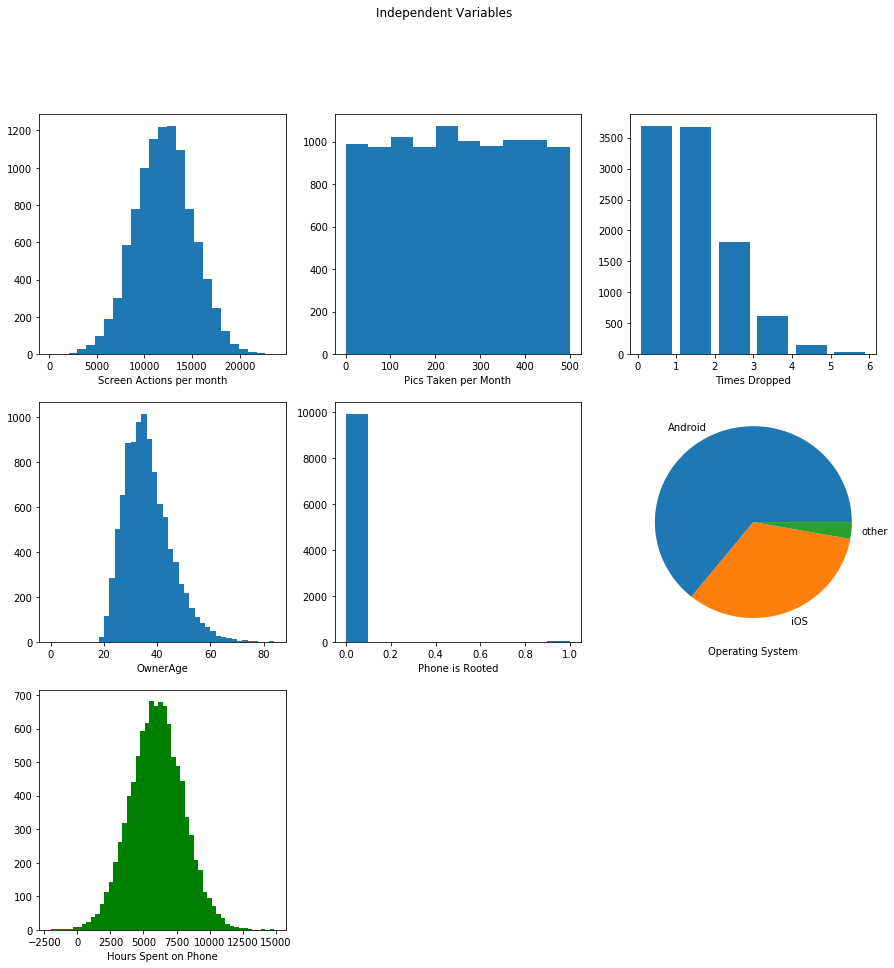

In [35]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsPerMonth)#, bins=np.arange(0,max(viz.df.picsPerMonth),25))
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),2))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
viz.df['os'].value_counts().plot(kind='pie')
plt.xlabel('Operating System')
plt.ylabel('')
plt.subplot(337)
plt.hist(viz.df.hoursSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')

plt.show()







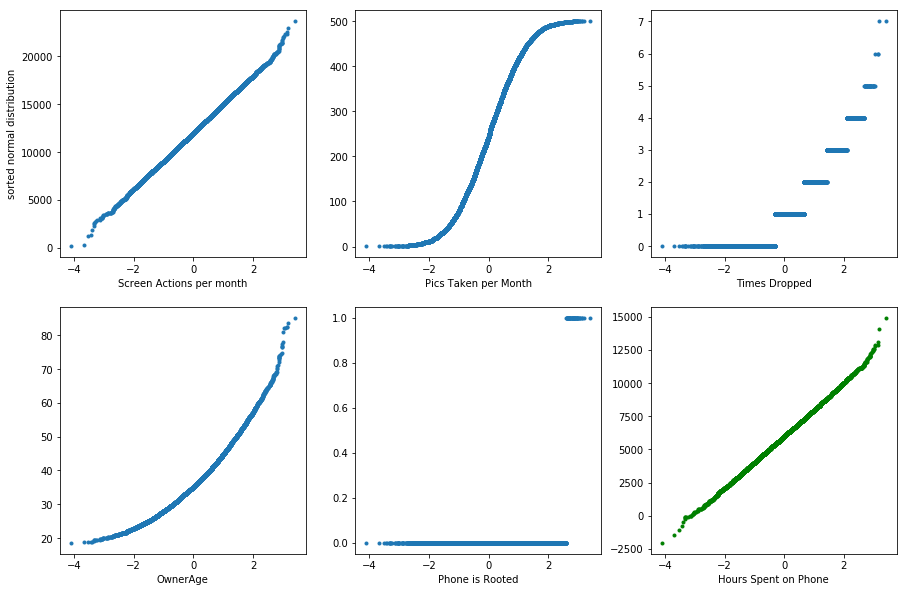

In [36]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsPerMonth'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['hoursSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.ylabel('sorted normal distribution')
plt.xlabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.xlabel('Pics Taken per Month')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.xlabel('Times Dropped')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.xlabel('OwnerAge')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.xlabel('Phone is Rooted')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.xlabel('Hours Spent on Phone')
plt.show()

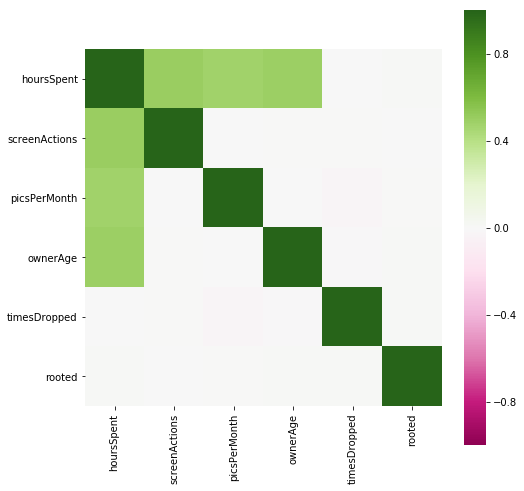

In [37]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

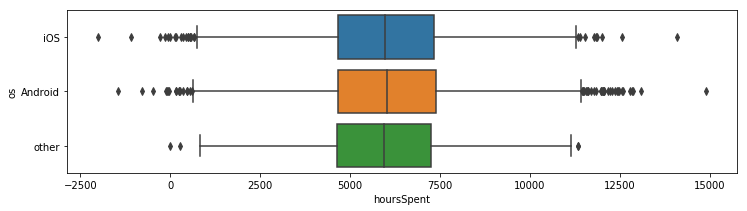

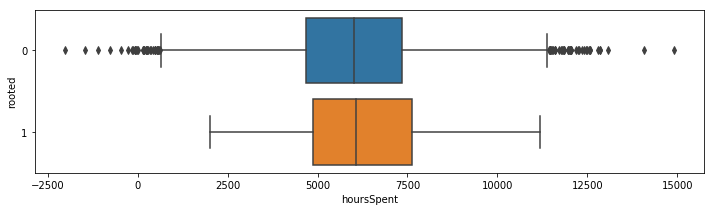

In [38]:
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [39]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [40]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression()

In [41]:
#sklearn
x = normal.df['screenActions']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.23668472 0.22281758 0.27703331 0.27780484 0.24256225 0.25665741
 0.25896202 0.22462351 0.25999543 0.27807138]

Average Score:  0.253521245745418

Coefficients: [0.33299813]

Intercept: 
 2001.7656594901096

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     3401.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:55:22   Log-Likelihood:                -88679.
No. Observations:               10000   AIC:                         1.774e+05
Df Residuals:                    9998   BIC:                         1.774e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2001.7657     70.561     28.369      0.000    1863.451    2140.080
screenActions     0.3330      0.006     58.314      0.000       0.322       0.344
==============================================================================
Omnibus:                        1.827   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.812
Skew:                          -0.011   Prob(JB):                        0.404
Kurtosis:                       2.938   Cond. No.                     5.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

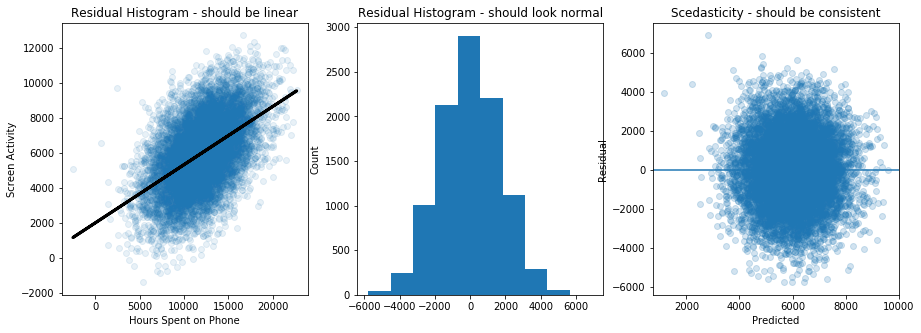

In [42]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# What if the target variable had a right skew instead of being normally distributed?

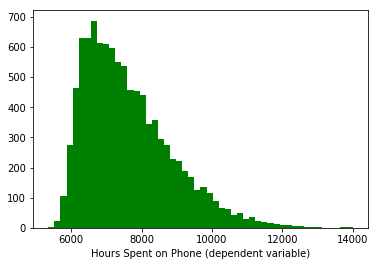

In [43]:
rightskew = createSet(targetskew=10, size=10000)
plt.hist(rightskew.df.hoursSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone (dependent variable)')
plt.show()

regr = linear_model.LinearRegression()

In [44]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.24252265 0.25032807 0.25811749 0.1758877  0.23951325 0.25587951
 0.27727116 0.1822981  0.21345535 0.21922412]

Average Score:  0.2314497411104625

Coefficients: [0.1997915]

Intercept: 
 5223.5501222191915

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     3045.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:55:23   Log-Likelihood:                -84030.
No. Observations:               10000   AIC:                         1.681e+05
Df Residuals:                    9998   BIC:                         1.681e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5223.5501     44.650    116.989      0.000    5136.027    5311.073
screenActions     0.1998      0.004     55.179      0.000       0.193       0.207
==============================================================================
Omnibus:                      969.705   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1306.098
Skew:                           0.804   Prob(JB):                    2.42e-284
Kurtosis:                       3.743   Cond. No.                     5.10e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

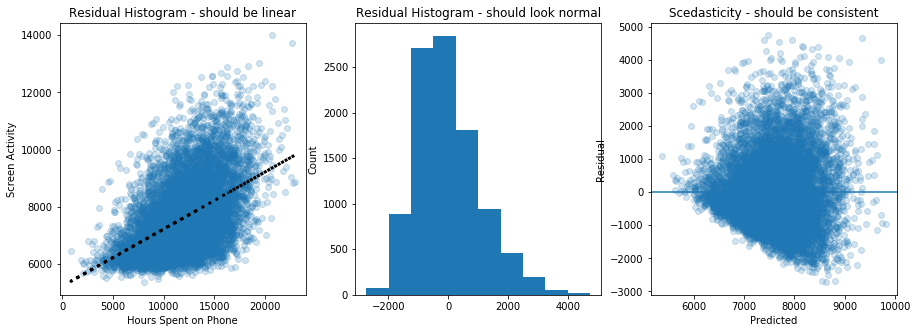

In [45]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [46]:
# If we use a transformation to reduce the skew, how much does it help?

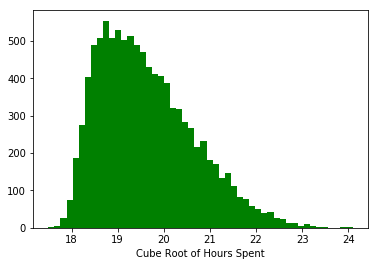

In [47]:
plt.hist(rightskew.df.hoursSpent**(1/3), color='g', bins=50)
plt.xlabel('Cube Root of Hours Spent')
plt.show()

In [48]:
rightskew.df['cube_rt_hoursSpent'] = rightskew.df['hoursSpent']**(1/3)
y = rightskew.df['cube_rt_hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'cube_rt_hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.24660591 0.25322173 0.2640136  0.18547434 0.2434373  0.26160399
 0.2821779  0.18663938 0.223079   0.22522458]

Average Score:  0.23714777240878968

Coefficients: [0.00016803]

Intercept: 
 17.6085053706734

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     cube_rt_hoursSpent   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     3139.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:55:24   Log-Likelihood:                -13069.
No. Observations:               10000   AIC:                         2.614e+04
Df Residuals:                    9998   BIC:                         2.616e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.6085      0.037    476.108      0.000      17.536      17.681
screenActions     0.0002      3e-06     56.028      0.000       0.000       0.000
==============================================================================
Omnibus:                      492.746   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              567.101
Skew:                           0.577   Prob(JB):                    7.17e-124
Kurtosis:                       3.167   Cond. No.                     5.10e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

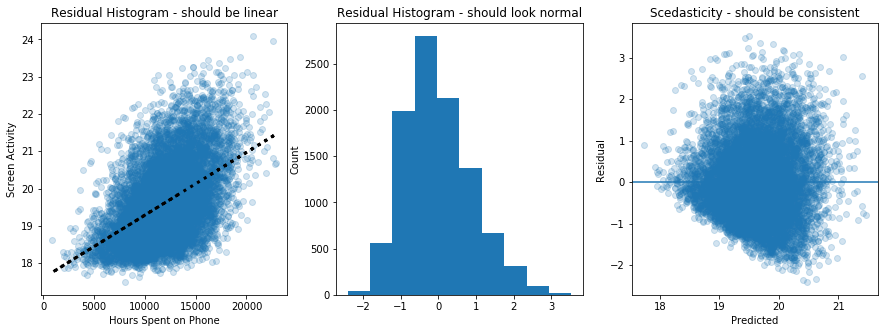

In [49]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# How do other types of regressors do?

In [50]:
from sklearn import neighbors
from sklearn import ensemble
#from sklearn.svm import SVR


In [51]:
print("NORMAL:\n")
x = normal.df['screenActions']
y = normal.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.2176316  0.18885396 0.24041629 0.25836955 0.22102572 0.21527139
 0.24022876 0.20418825 0.21508046 0.24321756]

Average Score with 30 neighbors:  0.22442835445493592

 ----------------------------------------
Random Forest Regressor:  [0.23997658 0.21337163 0.26807377 0.2742257  0.24262719 0.25292344
 0.25537943 0.22467168 0.25481378 0.26686652]

Average Score:  0.2492929718721661

 ----------------------------------------
Gradient-Boosted Regressor:  [0.23243083 0.21871416 0.27100335 0.27871111 0.24438043 0.2495783
 0.2552339  0.22415435 0.25453798 0.27004959]

Average Score:  0.24987939988319513

 ----------------------------------------


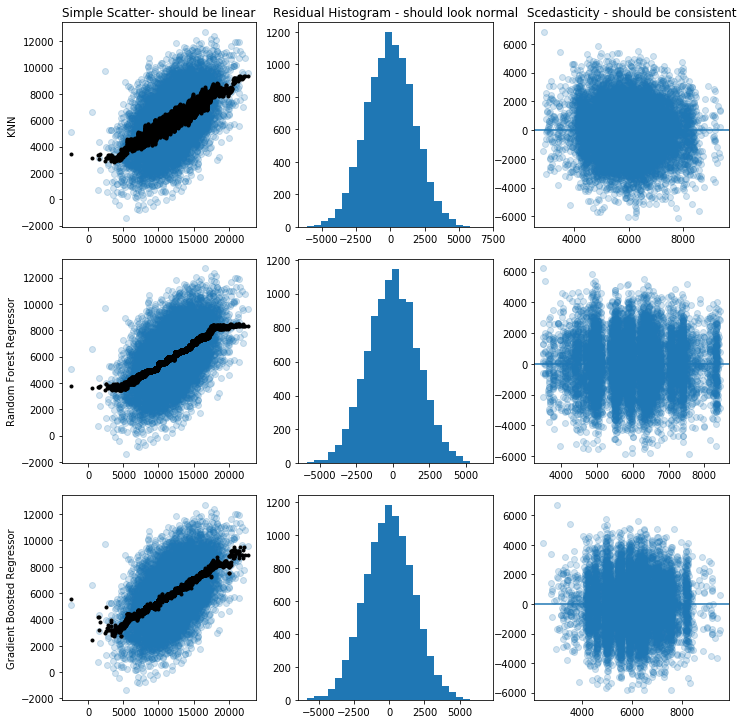

In [52]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [53]:
# Skewed Target Variable:

print("SKEWED TARGET VARIABLE:\n")
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

SKEWED TARGET VARIABLE:

KNN:  [0.2393748  0.23082873 0.24348877 0.15493249 0.21982694 0.21247656
 0.26847666 0.14733839 0.17617991 0.19722512]

Average Score with 30 neighbors:  0.20901483812709376

 ----------------------------------------
Random Forest Regressor:  [0.25111249 0.25455076 0.25179578 0.1691981  0.24133854 0.24586596
 0.27539727 0.1840075  0.20167556 0.22246151]

Average Score:  0.22974034724768

 ----------------------------------------
Gradient-Boosted Regressor:  [0.25243572 0.2583567  0.2576888  0.16681999 0.24227529 0.25061743
 0.27829471 0.18743496 0.20775349 0.22240926]

Average Score:  0.2324086351039975

 ----------------------------------------


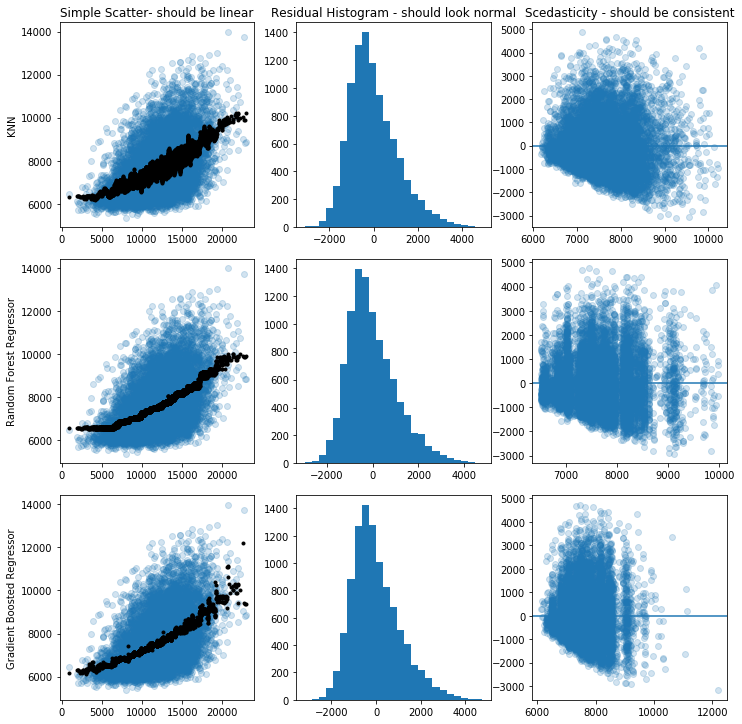

In [54]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [55]:
# Skewed Target Variable, adjusted:

print("Adjusted :\n")
x = rightskew.df['screenActions']
y = rightskew.df['cube_rt_hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

Adjusted :

KNN:  [0.2396017  0.22923308 0.25056735 0.1652804  0.2240498  0.21770115
 0.26868793 0.15125973 0.18611297 0.1997981 ]

Average Score with 30 neighbors:  0.21322922170597997

 ----------------------------------------
Random Forest Regressor:  [0.25114381 0.25565638 0.25920722 0.17800939 0.24575757 0.251647
 0.27783295 0.19120377 0.21407953 0.21911652]

Average Score:  0.2343654152936206

 ----------------------------------------
Gradient-Boosted Regressor:  [0.25305223 0.25644074 0.2640809  0.17846052 0.24541823 0.25612154
 0.28059796 0.18840563 0.21576198 0.2259644 ]

Average Score:  0.2364304140794172

 ----------------------------------------


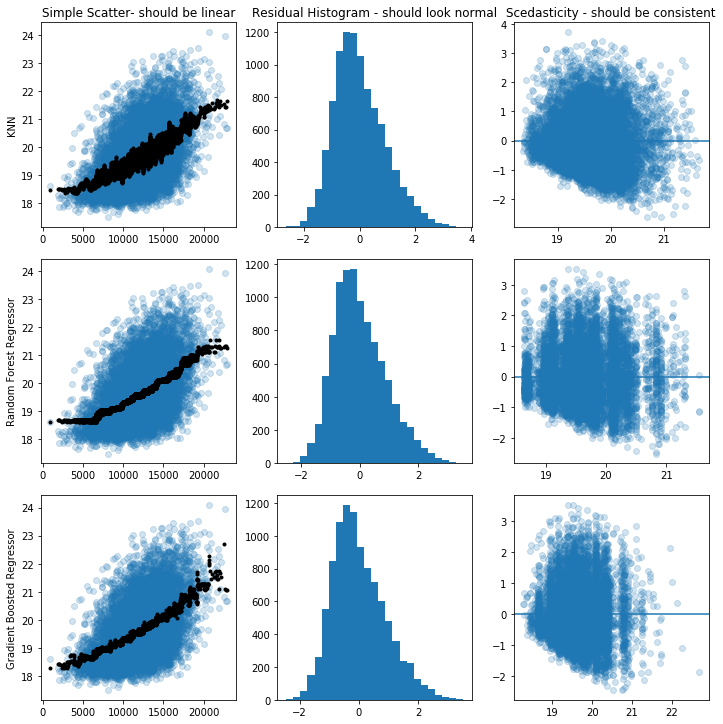

In [56]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Summary of 1-variable linear regression:
- 30% accurate when both dependent and independent variables are normally distributed
- If the Target Variable has a right skew, we lose 3% of accuracy, and additionally our model loses validity; our residuals tend to be large positives, and are much larger when the input variable is bigger.
- Cube-rooting the target variable to reduce the skew doesn't improve the R-squared score, but it does somewhat normalize residuals and scedasticity, which is useful.

KNN, Random Forest, and Gradient boosted regressors don't necessarily improve on the accuracy of simple linear regression, but they do seem to reduce the effects of a skewed target variable - in particular, Random Forest seems to extrapolate to the tail data better than any other model.


---------
# Attempting Linear Variable Regression with other data types

# 1: Normal Dependent variable,  1 Uniform feature

In [57]:
normal = createSet(targetskew=0, size=10000)
normal.df.head(2)

,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted,os
0,5515.182237,15881,61,39.159816,1,0,Android
1,4852.671795,8763,240,32.744787,0,0,other


In [58]:
#sklearn
x = normal.df['picsPerMonth']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ picsPerMonth'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.26403716 0.24936857 0.22058184 0.23752978 0.20217916 0.22197358
 0.20947915 0.22877458 0.22984473 0.23818201]

Average Score:  0.23019505656156153

Coefficients: [6.60743317]

Intercept: 
 4361.402943200932

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     3001.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:55:42   Log-Likelihood:                -88898.
No. Observations:               10000   AIC:                         1.778e+05
Df Residuals:                    9998   BIC:                         1.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4361.4029     34.834    125.204      0.000    4293.120    4429.686
picsPerMonth     6.6074      0.121     54.780      0.000       6.371       6.844
==============================================================================
Omnibus:                        1.035   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.596   Jarque-Bera (JB):                1.054
Skew:                          -0.002   Prob(JB):                        0.590
Kurtosis:                       2.950   Cond. No.                         573.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

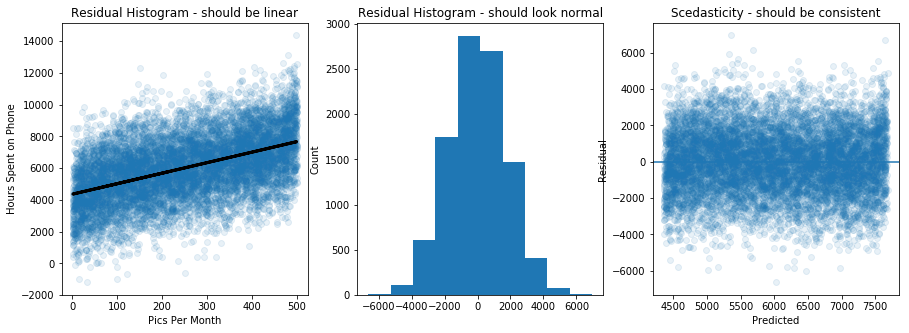

In [59]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Pics Per Month')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# Let's see how other models do

In [60]:
print("NORMAL:\n")
x = normal.df['picsPerMonth']
y = normal.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.24463188 0.2212129  0.2216092  0.234212   0.19099316 0.2047151
 0.2095733  0.20709737 0.19747092 0.22002579]

Average Score with 30 neighbors:  0.21515416287403627

 ----------------------------------------
Random Forest Regressor:  [0.26420527 0.25459101 0.2302472  0.25632275 0.2151418  0.22362494
 0.22571487 0.23433899 0.22907427 0.2386164 ]

Average Score:  0.2371877494445584

 ----------------------------------------
Gradient-Boosted Regressor:  [0.262291   0.25520848 0.23326326 0.25763524 0.21605466 0.22858827
 0.2266364  0.23314624 0.22956487 0.24042799]

Average Score:  0.2382816429132196

 ----------------------------------------


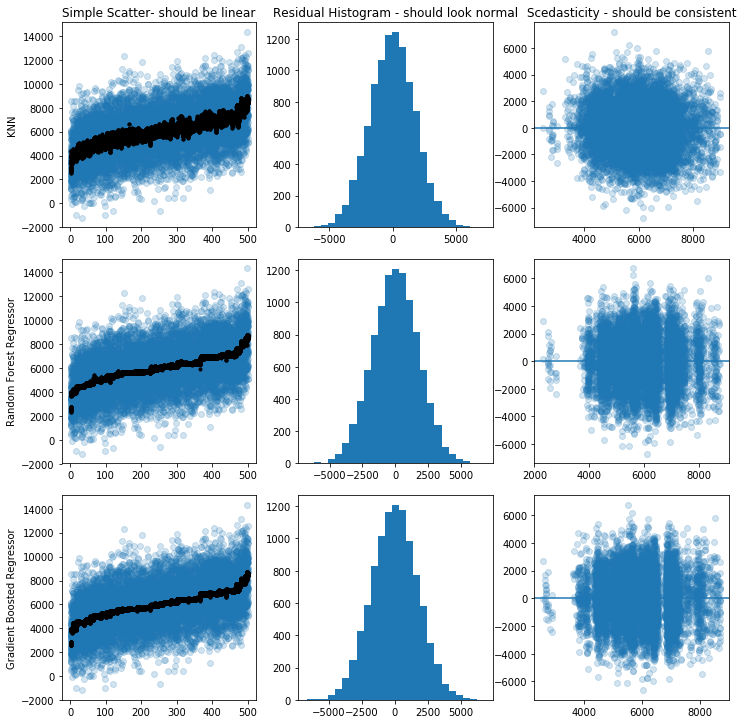

In [61]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# 1: Normal Dependent variable,  1 Gamma feature

In [62]:
normal = createSet(targetskew=0, size=10000)
normal.df.head(2)

,hoursSpent,screenActions,picsPerMonth,ownerAge,timesDropped,rooted,os
0,6301.489009,12960,355,35.895443,1,0,Android
1,4616.967579,16148,123,30.365507,0,0,iOS


In [63]:
#sklearn
x = normal.df['ownerAge']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ ownerAge'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.21604496 0.21604414 0.22935328 0.23265447 0.19318861 0.22238988
 0.26492135 0.20558637 0.22635117 0.237604  ]

Average Score:  0.2244138216045542

Coefficients: [106.54147564]

Intercept: 
 1968.7159692814666

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     2913.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:55:49   Log-Likelihood:                -88901.
No. Observations:               10000   AIC:                         1.778e+05
Df Residuals:                    9998   BIC:                         1.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1968.7160     76.575     25.710      0.000    1818.613    2118.819
ownerAge     106.5415      1.974     53.970      0.000     102.672     110.411
==============================================================================
Omnibus:                        0.540   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.560
Skew:                           0.017   Prob(JB):                        0.756
Kurtosis:                       2.984   Cond. No.                         169.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

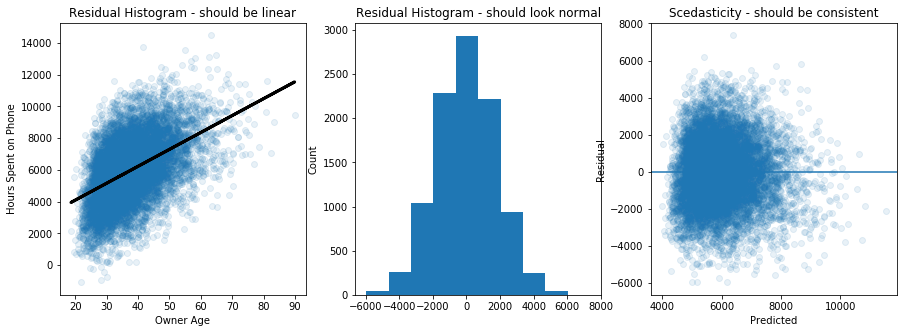

In [64]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Owner Age')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# Let's see how other models do

In [67]:
print("NORMAL:\n")
x = normal.df['ownerAge']
y = normal.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.19072557 0.21825123 0.21791395 0.23498144 0.18647804 0.21658133
 0.23763785 0.19321886 0.23278083 0.23496611]

Average Score with 30 neighbors:  0.21635352038037067

 ----------------------------------------
Random Forest Regressor:  [0.22354867 0.23320911 0.23896859 0.24845499 0.20278913 0.22558361
 0.26066052 0.21380884 0.24464252 0.24716713]

Average Score:  0.2338833104760755

 ----------------------------------------
Gradient-Boosted Regressor:  [0.2221654  0.22900775 0.23574088 0.25156604 0.20623711 0.22530377
 0.26074638 0.21328769 0.24281108 0.24994937]

Average Score:  0.23368154753954218

 ----------------------------------------


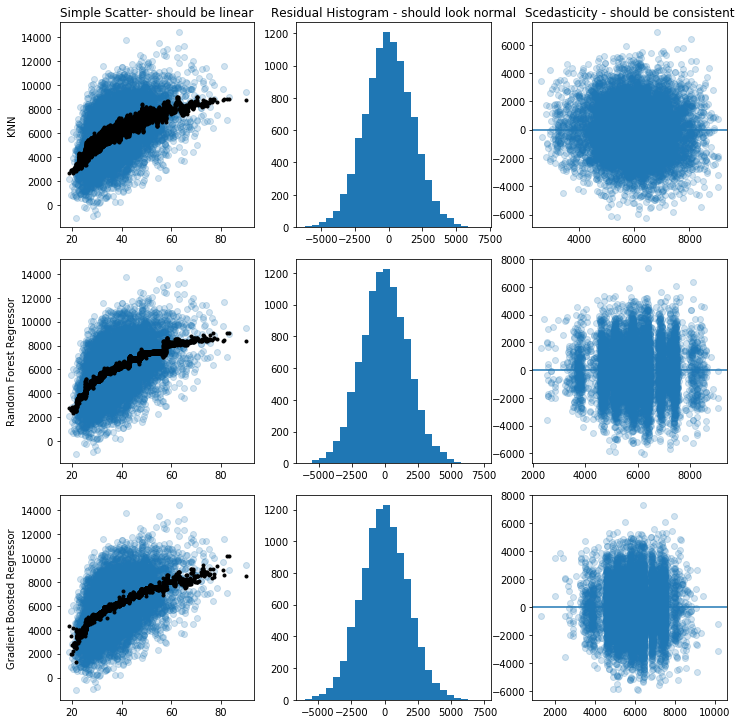

In [68]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

for i in range(10,50,5):
    rfr = ensemble.RandomForestRegressor(n_estimators=i, max_depth=3)
    rfr.fit(pd.DataFrame(x),y)
    scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
    print("\nAverage Score: ",np.mean(scores))

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC